In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from time import time
import matplotlib.patches as patches

In [11]:
class Target:
    def __init__(self, x, y, capacity, time_to_replenish):
        self.x = x
        self.y = y
        self.capacity = capacity
        self.time_to_replenish = time_to_replenish

    
class Danger:
    def __init__(self, x, y):
        self.x = x
        self.y = y

class Bee:
    def __init__(self, id, x, y, target = None):
        self.id = id
        self.x = x
        self.y = y
        self.velocity = np.array([0, 0])
        self.target = target
    
    def move(self):
        self.x += self.velocity[0]
        self.y += self.velocity[1]

class Hive:
    def __init__(self):
        self.bees = np.array([])
        self.targets = np.array([])
        self.dangers = np.array([])
    
    def add_bee(self, bee):
        self.bees = np.append(self.bees, bee)
    
    def find_neighbours(self, bee, radius):
        # Find all neighbours within a radius of a bee
        neighbours = []
        for other_bee in self.bees:
            if other_bee != bee:
                dist = np.sqrt((bee.x - other_bee.x)**2 + (bee.y - other_bee.y)**2)
                if dist < radius:
                    neighbours.append(other_bee)

        return neighbours
    
    def find_nearest_target(self, bee):
        if len(self.targets) == 0:
            return None
        
        # Find the nearest target of a bee
        min_dist = 1e10
        nearest_target = None
        for target in self.targets:
            dist = np.sqrt((bee.x - target.x)**2 + (bee.y - target.y)**2)
            if dist < min_dist and target.capacity > 0:
                min_dist = dist
                nearest_target = target


        if nearest_target:
            nearest_target.capacity -= 1

        return nearest_target
    
    def find_nearest_danger(self, bee):
        if len(self.dangers) == 0:
            return None
        # Find the nearest danger of a bee
        min_dist = 1e10
        for danger in self.dangers:
            dist = np.sqrt((bee.x - danger.x)**2 + (bee.y - danger.y)**2)
            if dist < min_dist:
                min_dist = dist
                nearest_danger = danger

        return nearest_danger

    def add_target(self, target):
        self.targets = np.append(self.targets, target)

    def add_danger(self, danger):
        self.dangers = np.append(self.dangers, danger)    

    def danger_velocity(self, bee, danger_c, panic_distance):
        danger = self.find_nearest_danger(bee)

        # Inside your graze() method
        if danger:
            danger_distance = np.sqrt((bee.x - danger.x)**2 + (bee.y - danger.y)**2)

            # If the bee is too close to the danger, it goes into panic mode
            if danger_distance < panic_distance:
                danger_velocity = np.array([bee.x - danger.x, bee.y - danger.y]) * danger_c
            else:
                # Otherwise, it uses an exponential function to calculate the danger_velocity
                danger_velocity = np.array([bee.x - danger.x, bee.y - danger.y]) * np.exp(-danger_distance) * danger_c

            return danger_velocity
        
        return np.array([0, 0])

    
    def target_velocity(self, bee, target_c, time_passed):
        target_velocity = np.array([0, 0])
        if bee.target and bee.target.time_to_replenish - time_passed > 0:
            # If the bee has a target, it moves towards it
            target_velocity = np.array([bee.target.x - bee.x, bee.target.y - bee.y]) * target_c
        else:
            # Otherwise, it moves towards the nearest target
            target = self.find_nearest_target(bee)

            
            # Attraction to the nearest target
            if target and target.time_to_replenish - time_passed > 0:
                bee.target = target
                target_velocity = np.array([target.x - bee.x, target.y - bee.y]) * target_c

        return target_velocity
    # momentum=0.8, velocity=0.05, target_c=0.03, danger_c=2, panic_distance=1, neighbour_c=0.6, repulsive_radius=1
    def graze(self,   
              time_passed,
              velocity = 0.05,   
              neighbour_c = 0.6, 
              momentum = 0.8, 
              repulsive_radius = 1, 
              target_c = 0.03, 
              danger_c = 2, 
              panic_distance = 1.5, 
              max_velocity = 1
              ):
        # Move each bee by a random amount
        
        self.panic_distance = panic_distance


        for bee in self.bees:
            rand_velocity = np.array([np.random.uniform(-velocity, velocity), np.random.uniform(-velocity, velocity)]) * np.random.uniform(0.01, 1)

            # Neighbour Repulsion velocity                        
            neighbours = self.find_neighbours(bee, repulsive_radius)
            neighbour_velocity = np.array([0, 0])
            if len(neighbours) > 0:
                # Repulsion from the nearest neighbour
                eps = 0.01
                neighbour_velocity = np.array([0, 0])
                for neighbour in neighbours:
                    neighbour_distance = np.sqrt((bee.x - neighbour.x)**2 + (bee.y - neighbour.y)**2)
                    neighbour_velocity = (np.array([bee.x - neighbour.x, bee.y - neighbour.y]) / (neighbour_distance**2 + eps) * neighbour_c) / len(neighbours)

            # Target velocity
            target_velocity = self.target_velocity(bee, target_c, time_passed)

            # Danger velocity
            danger_velocity = self.danger_velocity(bee, danger_c, panic_distance)

            resultant_velocity = rand_velocity + neighbour_velocity + target_velocity + danger_velocity 

            bee.velocity = momentum * bee.velocity + (1 - momentum) * resultant_velocity 

            speed = np.linalg.norm(bee.velocity)
            if speed > max_velocity or speed < -max_velocity:
                bee.velocity = (bee.velocity / speed) * max_velocity


            bee.move()


    def createBees(self, n, minX, minY, maxX, maxY):        
        # Create n bees
        for i in range(n):
            # Create a bee at random location

            while True:
                x = np.random.uniform(minX, maxX)
                y = np.random.uniform(minY, maxY)
                bee = Bee(i, x, y)
                
                # Check if bee is too close to another bee
                too_close = False
                for other_bee in self.bees:
                    if np.sqrt((x - other_bee.x)**2 + (y - other_bee.y)**2) < 0.1:
                        too_close = True
                        break

                # If bee is not too close, add it to the hive
                if not too_close:
                    self.add_bee(bee)    
                    break
                
    def plotHive(self):
        # Plot the targets (flowers)
        for target in self.targets:
            plt.plot(target.x, target.y, '*', color='green', markersize=5)

        # Plot the dangers (obstacles)
        for danger in self.dangers:
            plt.plot(danger.x, danger.y, 'ro', markersize=5)
            circle = patches.Circle((danger.x, danger.y), radius=self.panic_distance - 0.2, edgecolor='r', facecolor='r')
            plt.gca().add_patch(circle)

        plt.scatter([bee.x for bee in self.bees], [bee.y for bee in self.bees], s=9, color='#B8860B')


def create_objects(num_targets=10, num_dangers=10, x_bound=50, y_bound=50, min_distance=2, time_to_replenish=10):
    targets = []
    dangers = []
    
    for _ in range(num_targets):
        while True:
            potential_target = Target(np.random.uniform(0, x_bound), np.random.uniform(0, y_bound), capacity=3, time_to_replenish=np.random.randint(2,time_to_replenish))
            
            if all(np.sqrt((x.x - potential_target.x)**2 + (x.y - potential_target.y)**2) >= min_distance for x in targets + dangers):
                targets.append(potential_target)
                break

    for _ in range(num_dangers):
        while True:
            potential_danger = Danger(np.random.uniform(0, x_bound), np.random.uniform(0, y_bound))
            

            if all(np.sqrt((x.x - potential_danger.x)**2 + (x.y - potential_danger.y)**2) >= min_distance for x in targets + dangers):
                dangers.append(potential_danger)
                break  
    
    return targets, dangers




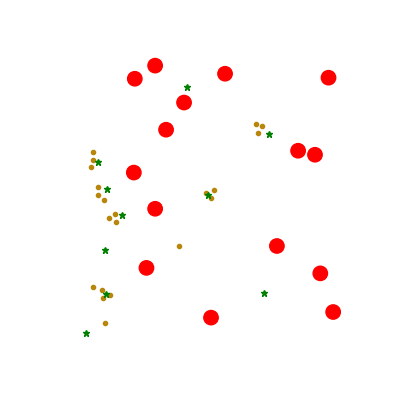

In [13]:
hive = Hive()

# Configurations of the simulation
BOUNDARIES = [0, 50, 0, 50]
FRAMES = 300
FPS = 60
VIDEO_LENGTH = FRAMES / FPS
FRAME_LENGTH = 1 / FPS
VIDEO_NAME = 'BEES.mp4'

TIME_PROPERTIES = [VIDEO_LENGTH, FPS, FRAMES]

minX, maxX, minY, maxY = BOUNDARIES

hive.createBees(21, 0, 0, 50, 50)

targets, dangers = create_objects(num_targets=10, num_dangers=15, x_bound=50, y_bound=50, time_to_replenish=VIDEO_LENGTH)

for target in targets:
    hive.add_target(target)

for danger in dangers:
    hive.add_danger(danger)


def animate(i):

    plt.cla()
    # Create a hive with 10 bees

    print(f'{i / FPS:.3f} seconds   ', end='\r')

    plt.xlim(-10, 60)
    plt.ylim(-10, 60)

    plt.axis('off')

    hive.graze(i / FPS)

    hive.plotHive()
    
start = time()

fig = plt.figure(figsize=(5, 5))

ani = FuncAnimation(fig, animate, frames=FRAMES, interval=FRAME_LENGTH * 1000, blit=False)
ani.save(VIDEO_NAME, fps=FPS, dpi=200)
#HTML(ani.to_html5_video())
